# Super Resolution

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Data

### Initial setup

Import libraries:

In [2]:
from fastai.conv_learner import *
from pathlib import Path
# torch.cuda.set_device(0)

torch.backends.cudnn.benchmark = True

Define directory and file paths:

In [3]:
PATH = Path('data/imagenet')
PATH_TRN = PATH / 'train'

We don't really have labels per se, so I'm just going to give everything a label of zero just so we can use it with our existing infrastructure more easily.

In [4]:
fnames_full, label_arr_full, all_labels = folder_source(PATH, 'train')
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full]
list(zip(fnames_full[:5], label_arr_full[:5]))

[('n01440764/n01440764_12241.JPEG', 0),
 ('n01440764/n01440764_529.JPEG', 0),
 ('n01440764/n01440764_11155.JPEG', 0),
 ('n01440764/n01440764_9649.JPEG', 0),
 ('n01440764/n01440764_8013.JPEG', 0)]

In [5]:
all_labels[:5]

['n01440764', 'n01443537', 'n01491361', 'n01494475', 'n01498041']

Now, because I'm pointing at a folder that contains all of ImageNet, I certainly don't want to wait for all of ImageNet to finish to run an epoch. So here, I'm just, most of the time, I would set "keep percent" (`keep_pct`) to 1 or 2%. And then I just generate a bunch of random numbers and then I just keep those which are less than 0.02 and so that lets me quickly subsample my rows.

In [6]:
np.random.seed(42)
keep_pct = 1.
# keep_pct = 0.02
keeps = np.random.rand(len(fnames_full)) < keep_pct
fnames = np.array(fnames_full, copy=False)[keeps]
label_arr = np.array(label_arr_full, copy=False)[keeps]

### Network architecture

**Backbone**

We are going to use VGG today even though it's ancient and it's missing lots of great stuff. One thing we are going to do though is use a slightly more modern version which is a version of VGG where batch norm has been added after all the convolutions. In fast.ai when you ask for a VGG network, you always get the batch norm one because that's basically always what you want.

In [7]:
arch = vgg16

# We are going to go from 72 by 72 low resolution
sz_lr = 72 # size low resolution

**Stage 1**

We are going to initially scale it up by times 2 with the batch size of 64 to get 2 * 72, so 144 by 144 output. That is going to be our stage one.

In [8]:
scale, bs = 2, 64
# scale, bs = 4, 32
sz_hr = sz_lr * scale

### Create our own dataset

I want a dataset where my *x*'s are images and my *y*'s are also images. There's already a files dataset inside the fastai.dataset module we can inherit from where the *x*'s are images and then I just inherit from that and I just copied and pasted the `get_x` and turn that into `get_y` so it just opens an image. What we're passing in is an array of files names.

In [9]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y = y
        assert(len(fnames) == len(y))
        super().__init__(fnames, transform, path)
        
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    
    def get_c(self): return 0

**Data augmentation**

`RandomDihedral` is referring to every possible 90 degree rotation plus optional left/right flipping so they are [dihedral group of eight symmetries](https://en.wikipedia.org/wiki/Dihedral_group#Elements). Normally we don't use this transformation for ImageNet pictures because you don't normally flip dogs upside down but in this case, we are not trying to classify whether it's a dog or a cat, we are just trying to keep the general structure of it. So actually every possible flip is a reasonably sensible thing to do for this problem.

In [10]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

In [11]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01 / keep_pct, 0.1))
((val_x, trn_x), (val_y, trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x), len(trn_x)

(194, 19245)

In [12]:
img_fn = PATH / 'train' / 'n01558993' / 'n01558993_9684.JPEG'

**Create Transformations**

We are going to use `tfm_y` parameter like we did for bounding boxes but rather than use `TfmType.COORD` we are going to use `TfmType.PIXEL`. That tells our transformations framework that your *y* values are images with normal pixels in them, so anything you do to the *x*, you also need to do the same thing to the *y*. You need to make sure any data augmentation transformations you use have the same parameter as well.

In [13]:
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

There is a handy little method called get datasets (`get_ds`) which basically runs that constructor over all the different things that you have to return all the datasets you need in exactly the right format to pass to a `ModelData` constructor (in this case the `ImageData` constructor).

### Look at an image from dataset

If we want to be able to display those pictures that have come out of our datasets or data loaders, we need to de-normalize them.

In [14]:
denorm = md.val_ds.denorm

A helper function that can show an image from a dataset and if you pass in something saying this is a normalized image, then we'll denorm it.

In [15]:
def show_img(ims, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if normed:
        ims = denorm(ims)
    else:
        ims = np.rollaxis(to_np(ims), 1, 4)
    ax.imshow(np.clip(ims, 0, 1)[idx])
    ax.axis('off')

In [16]:
x, y = next(iter(md.val_dl))
x.size(), y.size()

(torch.Size([32, 3, 72, 72]), torch.Size([32, 3, 288, 288]))

Here you can see the two different resolutions of our *x* and our *y* for a bird.

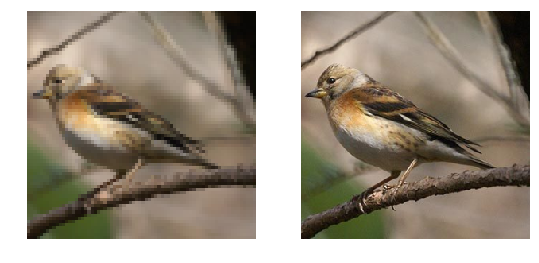

In [18]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
show_img(x, idx, ax=axes[0])
show_img(y, idx, ax=axes[1])

Next, let's have a look at a few different versions of the data transformation. There you can see them being flipped in all different directions.

In [19]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

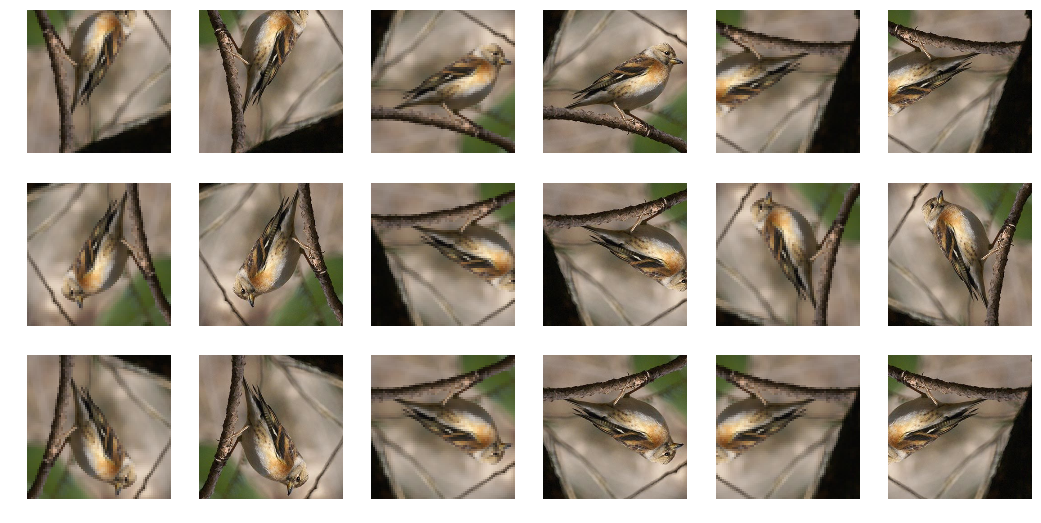

In [20]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i,(x, y) in enumerate(batches):
    show_img(x, idx, ax=axes.flat[i*2])
    show_img(y, idx, ax=axes.flat[i*2+1])

## Model

We are going to have a small image coming in, and we want to have a big image coming out. So we need to do some computation between those two to calculate what the big image would look like.

The way of doing that computation is, first do lots of stride one layers to do all the computation and then at the end do some upsampling.

We are going to create something with five ResNet blocks and then for each 2x scale up we have to do, we'll have one upsampling block.

In [21]:
def conv(ni, nf, kernel_size=3, actn=False):
    """Standard convolution block"""
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn:
        layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

### EDSR and SRResNet idea

_One interesting thing about our little conv block is that there is no batch norm which is pretty unusual for ResNet type models._

The reason there is no batch norm is because we are borrowing ideas from this fantastic [paper](https://arxiv.org/abs/1707.02921) which actually won a recent competition in super resolution performance.

So this paper was a really big step-up. They call their model EDSR (Enhanced Deep Super-Resolution network) and they did two things differently to the previous standard approaches:

1. Take the ResNet blocks and throw away the batch norms.
2. Scaling factor, `res_scale`.

In [22]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)
        
    def forward(self, x):
        return x + self.m(x) * self.res_scale

So we are going to create a residual block containing two convolutions. As you see in their approach, they don't even have a ReLU after their second conv. So that's why I've only got activation on the first one.

In [23]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)],
        0.1)

A couple of interesting things here. One is that this idea of having some kind of a main ResNet path (conv, ReLU, conv) and then turning that into a ReLU block by adding it back to the identity — it's something we do so often that I factored it out into a tiny little module called `ResSequential`.

What's `res_scale`? `res_scale` is the number 0.1. Why is it there?

Christian Szegedy who invented batch norm also somewhat more recently did a paper in which he showed for (I think) the first time the ability to train ImageNet in under an hour. Something Christian found was that in the ResNet blocks, if he multiplied them by some number smaller than 1, something like .1 or .2, it really helped stabilize training at the start.

In our case, we are just toning things down based on our initial initialization.

In [24]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale, 2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

So basically our super-resolution ResNet (`SrResnet`) is going to do a convolution to go from our three channels to 64 channels just to richen up the space a little bit. Then also we've got actually 8 not 5 Res blocks `res_block`. Remember, every one of these Res block is stride 1 so the grid size doesn't change, the number of filters doesn't change. It's just 64 all the way through. We'll do one more convolution, and then we'll do our upsampling by however much scale we asked for. Then something I've added which is one batch norm here because it felt like it might be helpful just to scale the last layer. Then finally conv to go back to the three channels we want.

In [25]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 64)]
        
        for i in range(8):
            features.append(res_block(64))

        features += [
            conv(64, 64),
            upsample(64, 64, scale),
            nn.BatchNorm2d(64),
            conv(64, 3)
        ]
        self.features = nn.Sequential(*features)

    def forward(self, x):
        return self.features(x)

The upsampling is a bit interesting because it is not doing either of two things (transposed or fractionally strided convolutions or nearest neighbor upsampling followed by a 1x1 conv) because that will cause the checkerboard patterns.

So instead, we are going to do the pixel shuffle. Pixel shuffle is an operation in this sub-pixel convolutional neural network. Refer to [_Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network_](https://arxiv.org/abs/1609.05158) paper to find out more.

## Pixel loss

Initialize the model and sent it to GPU:

In [26]:
m = to_gpu(SrResnet(64, scale))

To make life faster, we are going to run things in parallel.

Take your PyTorch module and wrap it with DataParallel. Once you've done that, it copies it to each of your GPUs and will automatically run it in parallel. It scales pretty well to two GPUs, okay to three GPUs, better than nothing to four GPUs and beyond that, performance does go backwards. _Note, by default, it will copy it to all of your GPUs._

In [ ]:
# Uncomment this line if you have more than 1 GPU.
# m = nn.DataParallel(m, [0, 2])

We create our learner the usual way.

We can use MSE loss here so that's just going to compare the pixels of the output to the pixels that we expected.

In [27]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)
learn.crit = F.mse_loss

We can run our learning rate finder and we can train it for a while.

 30%|███       | 183/602 [03:10<07:17,  1.04s/it, loss=9.88] 

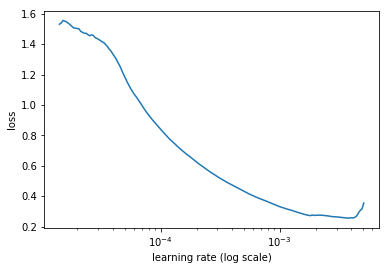

In [28]:
learn.lr_find(start_lr=1e-5, end_lr=10000)
learn.sched.plot(10, 0)

In [29]:
lr = 2e-3

In [30]:
learn.fit(lr, 1, cycle_len=1, use_clr_beta=(40, 10))

epoch      trn_loss   val_loss                               
    0      0.103036   0.09909   


[array([0.09909])]

In [31]:
x, y = next(iter(md.val_dl))
preds = learn.model(VV(x))

Ground truth image (high-res)

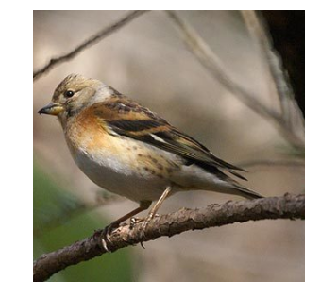

In [44]:
idx = 1
show_img(y, idx, normed=True)

Upsampled version (output)

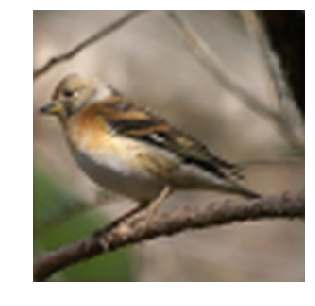

In [45]:
show_img(preds, idx, normed=True)

You can see that what we've managed to do is to train a very advanced residual convolutional network that's learnt to blur things. Why is that? Well, because it's what we asked for. We said to minimize MSE loss. MSE loss between pixels really the best way to do that is just average the pixel i.e. to blur it. So that's why pixel loss is no good. So we want to use our perceptual loss.

Pixelated version as input image (low-res)

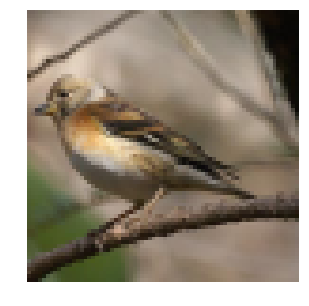

In [46]:
show_img(x, idx, normed=True)

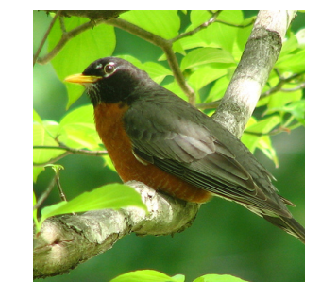

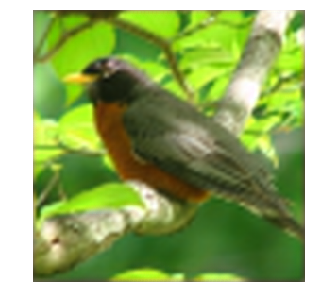

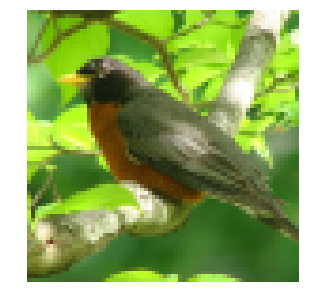

In [48]:
idx = 2

# Ground truth image (high-res)
show_img(y, idx, normed=True)

# Upsampled image (output)
show_img(preds, idx, normed=True)

# Input image (low-res)
show_img(x, idx, normed=True)

## Perceptual loss

With perceptual loss, we are basically going to take our VGG network and we are going to find the block index just before we get a maxpool.

In [56]:
m_vgg = vgg16(True)

blocks = [i - 1 for i, o in enumerate(children(m_vgg)) 
                    if isinstance(o, nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

So here are the ends of each block of the same grid size. If we just print them out, as we'd expect, every one of those is a ReLU module and so in this case these last two blocks are less interesting to us. The grid size there is small enough, and course enough that it's not as useful for super resolution. So we are just going to use the first three.

Just to save unnecessary computation, we are just going to use those first 23 layers of VGG and we'll throw away the rest. We'll stick it on the GPU. We are not going to be training this VGG model at all — we are just using it to compare activations. So we'll stick it in eval mode and we will set it to not trainable.

In [57]:
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [58]:
def flatten(x): return x.view(x.size(0), -1)

We will use `SaveFeatures` class to do a forward hook which saves the output activations at each of those layers:

In [59]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

**Loss function**

We are going to pass in a list of layer IDs, the layers where we want the content loss to be calculated, and a list of weights for each of those layers. We can go through each of those layer IDs and create an object which has the forward hook function to store the activations. So in our forward, then we can just go ahead and call the forward pass of our model with the target (high res image we are trying to create). The reason we do that is because that is going to then call that hook function and store in `self.sfs` (self dot save features) the activations we want. Now we are going to need to do that for our conv net output as well. So now we can do the same thing for the conv net output which is the input to the loss function. And so now we've got those two things we can zip them all together along with the weights so we've got inputs, targets, and weights. Then we can do the L1 loss between the inputs and the targets and multiply by the layer weights. The only other thing I do is I also grab the pixel loss, but I weight it down quite a bit. Most people don't do this. I haven't seen papers that do this, but in my opinion, it's maybe a little bit better because you've got the perceptual content loss activation stuff but the really finest level it also cares about the individual pixels.

In [60]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m, self.wgts = m, layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]
    
    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input, target) / 100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(flatten(inp.features), flatten(targ)) * wgt
               for inp, targ, wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

### Model

We create our super resolution ResNet telling it how much to scale up by.

In [80]:
m = SrResnet(64, scale)

ICNR initialization of pixel shuffle convolution:

Al it does is you've got some weight tensor `x` that you want to initialize so we are going to treat it as if it has shape (i.e. number of features) divided by scale squared features in practice. So this might be 2² = 4 because we actually want to just keep one set of then and then copy them four times, so we divide it by four and we create something of that size and we initialize that with, by default, `kaiming_normal` initialization. Then we just make `scale`² copies of it. And the rest of it is just kind of moving axes around a little bit. So that's going to return a new weight matrix where each initialized sub kernel is repeated r² or `scale`² times.

In [81]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

I looked through to find what was the actual conv layer just before the pixel shuffle and store it away and then I called `icnr` on its weight matrix to get my new weight matrix. And then I copied that new weight matrix back into that layer.

In [82]:
conv_shuffle = m.features[10][0][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel)


( 0 , 0 ,.,.) = 
  1.8146e-02  1.6522e-02 -4.5680e-02
  1.4698e-01 -4.3911e-02 -1.0781e-01
 -3.7136e-02  2.8169e-02 -5.4919e-02

( 0 , 1 ,.,.) = 
 -9.4223e-03  4.8120e-03  1.2946e-02
 -3.9272e-02 -3.8658e-02  1.3500e-02
 -4.1916e-02  9.4384e-02  5.7070e-03

( 0 , 2 ,.,.) = 
  2.5559e-02  7.9318e-02  1.1428e-01
  5.6322e-03 -8.2761e-02  1.0861e-01
 -9.0112e-02 -6.2754e-02 -7.7496e-03
    ... 

( 0 ,61 ,.,.) = 
  8.8651e-02 -7.3459e-02  5.3821e-02
  3.1065e-02 -2.0956e-02  1.0280e-01
  3.7613e-02  8.5804e-02  8.4864e-02

( 0 ,62 ,.,.) = 
 -3.6131e-02 -1.9557e-02  5.7374e-02
 -2.5727e-02  8.1422e-02  4.8493e-02
 -2.3257e-02  3.5281e-02  5.1659e-03

( 0 ,63 ,.,.) = 
 -7.6315e-03  8.5549e-02  1.1188e-02
  6.0237e-02  6.0332e-02 -2.5704e-02
 -7.1704e-02  3.0991e-02 -5.5966e-02
      ⋮  

( 1 , 0 ,.,.) = 
  1.8146e-02  1.6522e-02 -4.5680e-02
  1.4698e-01 -4.3911e-02 -1.0781e-01
 -3.7136e-02  2.8169e-02 -5.4919e-02

( 1 , 1 ,.,.) = 
 -9.4223e-03  4.8120e-03  1.2946e-02
 -3.9272e-02 -3.8658e-0

In [83]:
m = to_gpu(m)

We create our learner the usual way.

In [84]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

_Note, if you are trying to replicate this, **don't just run this top to bottom**. Realize it involves a bit of jumping around._

#### Progressive resizing

_Note, **don't run the next 4 cell** until you completed training for stage 1, which is at 2 scale, 64 batch size._

For stage 2, the next step is to go all the way back to the top and change to 4 scale, 32 batch size, restart. I saved the stage 1 model before I do that.

That's why there's a little bit of fussing around in here below with reloading because what I needed to do now is I needed to load my saved model back in.

In [ ]:
t = torch.load(learn.get_model_path('sr-samp0'), map_location=lambda storage, loc: storage)
learn.model.load_state_dict(t, strict=False)

In [ ]:
learn.freeze_to(999)

In [ ]:
for i in range(10, 13): set_trainable(m.features[i], True)

In [ ]:
conv_shuffle = m.features[10][2][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel)

In [ ]:
# Uncomment this line if you have more than 1 GPU
# m = nn.DataParallel(m, [0, 2])

In [ ]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [ ]:
learn.set_data(md)

#### Training

Set our criterion to be `FeatureLoss` using our VGG model, grab the first few blocks and these are sets of layer weights that I found worked pretty well.

In [85]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2, 0.7, 0.1])

In [86]:
wd = 1e-7

Do a learning rate finder.

In [87]:
%time learn.lr_find(1e-4, 0.1, wds=wd, linear=True)

 12%|█▏        | 71/602 [03:10<23:44,  2.68s/it, loss=0.807] CPU times: user 4min 32s, sys: 17.9 s, total: 4min 50s
Wall time: 3min 10s


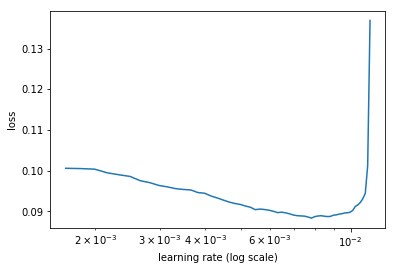

In [88]:
learn.sched.plot(n_skip_end=1)

Set the starting learning rate:

In [89]:
lr = 6e-3

Fit it for a while.

In [90]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr=(20, 10))

epoch      trn_loss   val_loss                                
    0      0.06387    0.062875  
    1      0.062231   0.060575                                


[array([0.06057])]

In [91]:
learn.save('sr-samp0')
learn.load('sr-samp0')

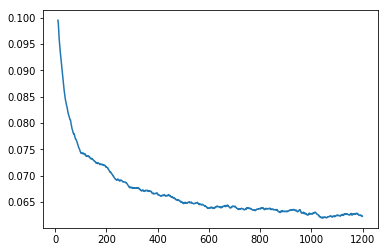

In [92]:
learn.sched.plot_loss()

In [108]:
learn.unfreeze()

In [109]:
learn.load('sr-samp0')

In [110]:
learn.fit(lr / 3, 1, cycle_len=1, wds=wd, use_clr=(20, 10))

epoch      trn_loss   val_loss                                
    0      0.063521   0.060426  


[array([0.06043])]

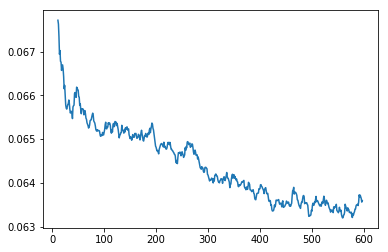

In [112]:
learn.sched.plot_loss()

In [113]:
learn.save('sr1')

### Check results

As before, we create a helper function to plot images from dataset.

In [93]:
def plot_ds_img(idx, ax=None, figsize=(7, 7), normed=True):
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    im = md.val_ds[idx][0]
    if normed: im = denorm(im)[0]
    else:      im = np.rollaxis(to_np(im), 0, 3)
    ax.imshow(im)
    ax.axis('off')

Plot some images from the validation dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


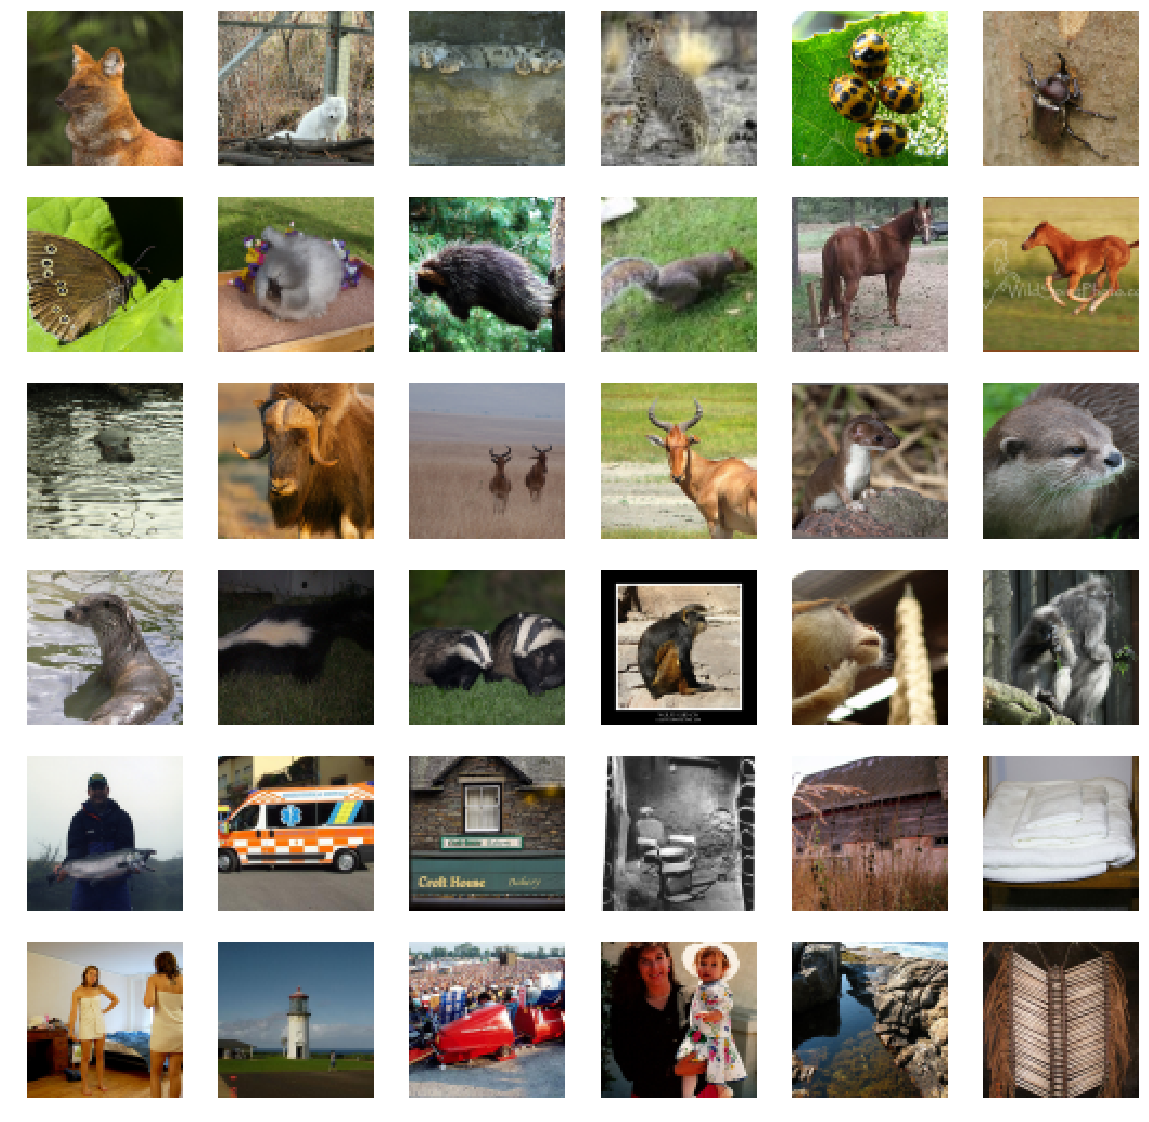

In [111]:
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    plot_ds_img(i + 35, ax=ax, normed=True)

#### Evaluate model

In [120]:
x, y = md.val_ds[41]

In [121]:
y = y[None]

In [122]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape, y.shape, preds.shape

((3, 72, 72), (1, 3, 288, 288), torch.Size([1, 3, 288, 288]))

Call the model objective function, `FeatureLoss` to get our perceptual losses.

In [123]:
learn.crit(preds, V(y), sum_layers=False)

[Variable containing:
 1.00000e-03 *
   2.2764
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 1.00000e-02 *
   1.4666
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 1.00000e-02 *
   4.4654
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 1.00000e-03 *
   4.2357
 [torch.cuda.FloatTensor of size 1 (GPU 0)]]

In [125]:
learn.crit.close()

#### Final analysis

The longer you train, the better it gets. I ended up training it for about 10 hours, but you'll still get very good results much more quickly if you're less patient. So we can try it out and and here is the result. On the left is my pixelated butterfly and on the right is the upsampled version.

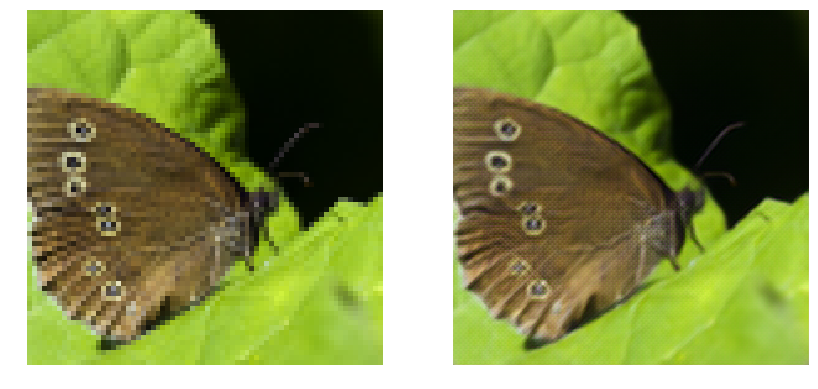

In [124]:
_, axes = plt.subplots(1, 2, figsize=(14, 7))
show_img(x[None], 0, ax=axes[0])
show_img(preds, 0, normed=True, ax=axes[1])